In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

%config InlineBackend.figure_format = 'retina'

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

## Setting datasets up

### Loading MNIST

In [4]:
mnist_X=np.load('data/mnist_X.npy')
mnist_y=np.load('data/mnist_y.npy')

In [5]:
shuffle = np.random.choice(range(mnist_X.shape[0]), size=(mnist_X.shape[0],), replace=False)
mnist_X=mnist_X[shuffle]
mnist_y=mnist_y[shuffle]

In [6]:
mnist_X = [cv2.cvtColor(m.astype('uint8'), cv2.COLOR_GRAY2BGR) for m in mnist_X]
mnist_X = np.array([cv2.resize(m, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)[:,:,0].tolist() for m in mnist_X])

### Normalizing pixels

In [7]:
mnist_X=mnist_X/np.max(mnist_X)

### Reshaping data

In [8]:
mnist_X=mnist_X.reshape(mnist_X.shape[0],-1)
mnist_X.shape

(70000, 256)

mnist_X=(mnist_X-np.mean(mnist_X, axis=0))
usps_X=(usps_X-np.mean(usps_X, axis=0))

### Dimension reduction

In [9]:
pca = PCA(n_components=10)
pca.fit(mnist_X)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

mnist_X=pca.transform(mnist_X)

[0.10243749 0.07433913 0.06470261 0.05681461 0.05115428 0.04543597
 0.03395039 0.0303794  0.02887601 0.02448199] 0.512571894723457


### Partitioning data in the T+1 periods 

In [10]:
T=11 #T+1 periods
C=int((mnist_X.shape[0])/(T+1))
T,C

(11, 5833)

In [11]:
X=[]
y=[]

mcum=0
ucum=0
theta=[]

for t in range(T+1):
    
    delta=C
    
    X.append(mnist_X[mcum:(mcum+delta)])
    y.append(mnist_y[mcum:(mcum+delta)])
    
    
    mcum+=delta
    
    
    print(X[0].shape)


(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)
(5833, 10)


## Detecting dataset shift

In [13]:
pvals=[]
kls=[]
covshift_models=[]
task='class'
test=.1
B=250

for t in tqdm(range(T+1)):

    ### Setting-up data
    Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
    Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(X[0], y[0], X[t], y[t], test=test, task=task, random_state=t)
    
    ### Training models
    totshift_model = KL(boost=True)
    totshift_model.fit(Zs_train, Zt_train)
    covshift_models.append(KL(boost=True))
    covshift_models[-1].fit(Xs_train, Xt_train)

    cd_model = cde_class(boost=True)
    cd_model.fit(pd.concat([Xs_train, Xt_train], axis=0), 
                 pd.concat([ys_train, yt_train], axis=0))
    
    ### Getting test statistics and p-vals
    out = ShiftDiagnostics(Xs_test, ys_test, Xt_test, yt_test,
                           totshift_model=totshift_model, covshift_model=covshift_models[-1], labshift_model=None,
                           cd_model=cd_model, task=task, B=B, verbose=False)

    ### Output
    pvals.append([0, out['lab']['pval'], out['cov']['pval'], out['conc1']['pval'], out['conc2']['pval'], out['tot']['pval']])
    kls.append([0, out['lab']['kl'], out['cov']['kl'], out['conc1']['kl'], out['conc2']['kl'], out['tot']['kl']])


100%|██████████| 12/12 [02:44<00:00, 13.68s/it]


In [14]:
kls=np.array(kls)
pvals=np.array(pvals)

Plots

(0.0, 1.0)

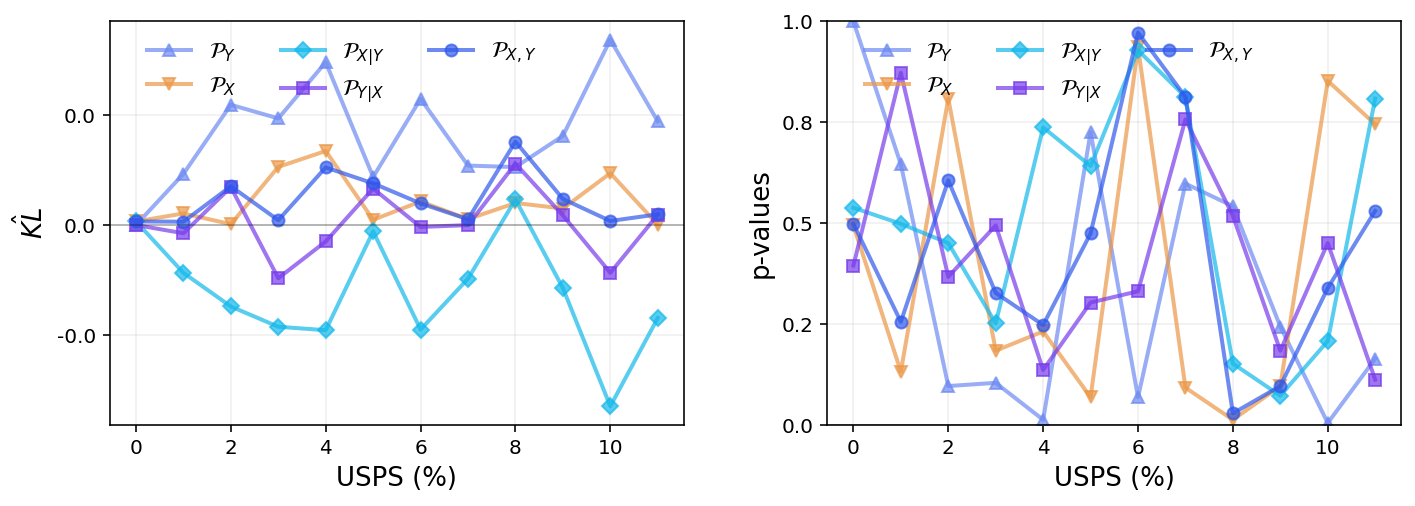

In [23]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.35   # the amount of height reserved for white space between subplots

plt.figure(figsize=(18,3.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

###SHIFTS
plt.subplot(1, 3, 1)
exp_plots([i for i in range(kls.shape[0])],kls, xlab="USPS (%)", ylab="$\hat{KL}$", grid='both')

plt.subplot(1, 3, 2)
exp_plots([i for i in range(kls.shape[0])],pvals, xlab="USPS (%)", ylab="p-values", grid='both')
plt.ylim(0,1)